In [ ]:
## 5 classes classification

In [1]:
import numpy as np
import os
import sys
import time
import argparse
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
sys.path.insert(0,'/home/prisimage/tracker/py-MDNetST/modules')
from sample_generator import *
from data_prov import *
from model import *
from bbreg import *
from options import *
from gen_config import *
from sklearn.neighbors import NearestNeighbors
def set_optimizer(model, lr_base, lr_mult=opts['lr_mult'], momentum=opts['momentum'], w_decay=opts['w_decay']):
    params = model.get_learnable_params()
    param_list = []
    for k, p in params.iteritems():
        lr = lr_base
        for l, m in lr_mult.iteritems():
            if k.startswith(l):
                lr = lr_base * m
        param_list.append({'params': [p], 'lr':lr})
    optimizer = optim.SGD(param_list, lr = lr, momentum=momentum, weight_decay=w_decay)
    return optimizer
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def forward_samples(model, image, samples, out_layer='conv3'):
    model.eval()
    extractor = RegionExtractor(image, samples, opts['img_size'], opts['padding'], opts['batch_test'])
    for i, regions in enumerate(extractor):
        regions = Variable(regions)
        if opts['use_gpu']:
            regions = regions.cuda()
        feat = model(regions, out_layer=out_layer)
        if i==0:
            feats = feat.data.clone()
        else:
            feats = torch.cat((feats,feat.data.clone()),0)
    return feats
def train(model, criterion, optimizer, pos_feats, neg_feats, maxiter, in_layer='fc4'):
    model.train()
    
    batch_pos = opts['batch_pos']
    batch_neg = opts['batch_neg']
    batch_test = opts['batch_test']
    batch_neg_cand = max(opts['batch_neg_cand'], batch_neg)

    pos_idx = np.random.permutation(pos_feats.size(0))
    neg_idx = np.random.permutation(neg_feats.size(0))
    while(len(pos_idx) < batch_pos*maxiter):
        pos_idx = np.concatenate([pos_idx, np.random.permutation(pos_feats.size(0))])
    while(len(neg_idx) < batch_neg_cand*maxiter):
        neg_idx = np.concatenate([neg_idx, np.random.permutation(neg_feats.size(0))])
    pos_pointer = 0
    neg_pointer = 0

    for iter in range(maxiter):

        # select pos idx
        pos_next = pos_pointer+batch_pos
        pos_cur_idx = pos_idx[pos_pointer:pos_next]
        pos_cur_idx = pos_feats.new(pos_cur_idx).long()
        pos_pointer = pos_next

        # select neg idx
        neg_next = neg_pointer+batch_neg_cand
        neg_cur_idx = neg_idx[neg_pointer:neg_next]
        neg_cur_idx = neg_feats.new(neg_cur_idx).long()
        neg_pointer = neg_next

        # create batch
        batch_pos_feats = Variable(pos_feats.index_select(0, pos_cur_idx))
        batch_neg_feats = Variable(neg_feats.index_select(0, neg_cur_idx))

        # hard negative mining
        if batch_neg_cand > batch_neg:
            model.eval()
            for start in range(0,batch_neg_cand,batch_test):
                end = min(start+batch_test,batch_neg_cand)
                score = model(batch_neg_feats[start:end], in_layer=in_layer)
                if start==0:
                    neg_cand_score = score.data[:,1].clone()
                else:
                    neg_cand_score = torch.cat((neg_cand_score, score.data[:,1].clone()),0)

            _, top_idx = neg_cand_score.topk(batch_neg)
            batch_neg_feats = batch_neg_feats.index_select(0, Variable(top_idx))
            model.train()
        
        # forward
        pos_score = model(batch_pos_feats, in_layer=in_layer)
        neg_score = model(batch_neg_feats, in_layer=in_layer)
        
        # optimize
        loss = criterion(pos_score, neg_score)
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), opts['grad_clip'])
        optimizer.step()

        #print "Iter %d, Loss %.4f" % (iter, loss.data[0])
#import cv2
def cvshow(img):
    cv2.imshow("Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

        
def stackList(featList):
    nframes = len(featList)
    for start in range(nframes):
        if start == 0:
            pos_data = featList[start].data.clone()
        else:
            pos_data = torch.cat((pos_data,featList[start].data.clone()),0)
    return pos_data


In [2]:
import torchvision

In [6]:
np.random.seed(123)
torch.manual_seed(456)
torch.cuda.manual_seed(789)
seq_home = '../dataset/OTB'
save_home = '../result_fig'
result_home = '../result'
        
seq_name = 'Basketball'
img_dir = os.path.join(seq_home, seq_name, 'img')
gt_path = os.path.join(seq_home, seq_name, 'groundtruth_rect.txt')

img_list = os.listdir(img_dir)
img_list.sort()
img_list = [os.path.join(img_dir,x) for x in img_list]

gt = np.loadtxt(gt_path,delimiter=',')
init_bbox = gt[0]
        
savefig_dir = os.path.join(save_home,seq_name)
result_dir = os.path.join(result_home,seq_name)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir,'result.json')
# get imglist,gt
target_bbox = np.array(init_bbox)
result = np.zeros((len(img_list),4))
result_bb = np.zeros((len(img_list),4))
result[0] = target_bbox
result_bb[0] = target_bbox
#init the first target box and result array
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"
model = MDNet(opts['model_path'])
if opts['use_gpu']:
    model = model.cuda()
model.set_learnable_params(opts['ft_layers'])
#init model and set learnable layers
criterion = BinaryLoss()
criterion5 = BinaryLoss(5,1)
init_optimizer = set_optimizer(model, opts['lr_init'])
update_optimizer = set_optimizer(model, opts['lr_update'])
image = Image.open(img_list[0]).convert('RGB')
bbreg_examples = gen_samples(SampleGenerator('uniform', image.size, 0.3, 1.5, 1.1),target_bbox, opts['n_bbreg'], opts['overlap_bbreg'], opts['scale_bbreg'])
bbreg_feats = forward_samples(model, image, bbreg_examples)
bbreg = BBRegressor(image.size)
bbreg.train(bbreg_feats, bbreg_examples, target_bbox)
#train bbreg


In [7]:
i=0

In [ ]:
## class 1 : pure bg

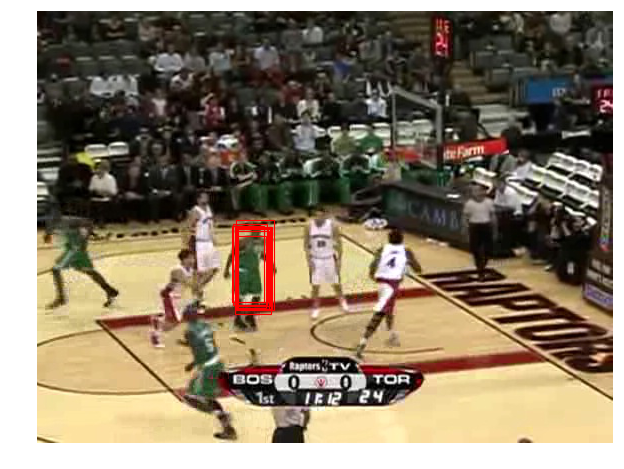

In [8]:
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
neg_examples = gen_samples(SampleGenerator('uniform', image.size, 1,2,1.1),target_bbox, 1000, [0,0.1])
#neg_examples = gen_samples(SampleGenerator('hole', image.size, 0.3,2.0),target_bbox, 1000, [0,0.5])
#eg_examples = gen_samples(SampleGenerator('edge', image.size, 1,2.0,1.1),target_bbox, 1000, [0.2,0.6])
neg_examples.shape
show_bbox(image,pos_examples[:10,:])

/home/prisimage/tracker/py-MDNetST/modules/model.py:156: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pos_loss = -F.log_softmax(pos_score)[:,1]
/home/prisimage/tracker/py-MDNetST/modules/model.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  neg_loss = -F.log_softmax(neg_score-5)[:,0]


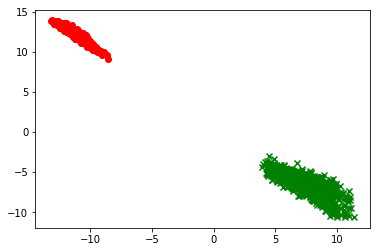

In [9]:
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats
train(model, criterion, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')
plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')

In [ ]:
##class 2 : over include(hole)

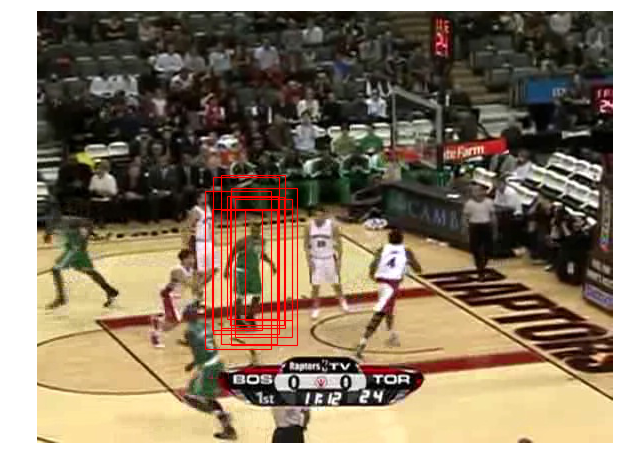

In [10]:
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),
                           target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
#neg_examples = gen_samples(SampleGenerator('uniform', image.size, 1,2,1.1),target_bbox, 1000, [0,0.1])
neg_examples = gen_samples(SampleGenerator('hole', image.size, 0.3,2.0),target_bbox, 1000, [0,0.5])
#eg_examples = gen_samples(SampleGenerator('edge', image.size, 1,2.0,1.1),target_bbox, 1000, [0.2,0.6])
neg_examples.shape
show_bbox(image,neg_examples[:10,:])

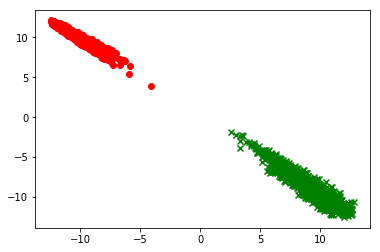

In [11]:
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats
train(model, criterion, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')
plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')

In [ ]:
## class 3: edge(part + bg)

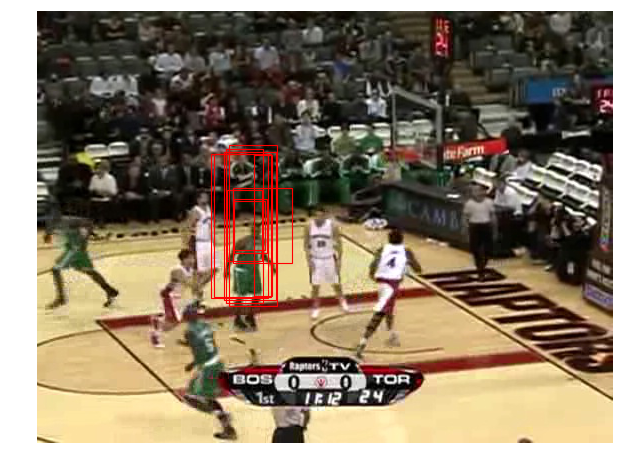

In [12]:
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),
                           target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
#neg_examples = gen_samples(SampleGenerator('uniform', image.size, 1,2,1.1),target_bbox, 1000, [0,0.1])
#neg_examples = gen_samples(SampleGenerator('hole', image.size, 0.3,2.0),target_bbox, 1000, [0,0.5])
neg_examples = gen_samples(SampleGenerator('edge', image.size, 1,2.0,1.1),target_bbox, 1000, [0.2,0.6])
neg_examples.shape
show_bbox(image,neg_examples[:10,:])

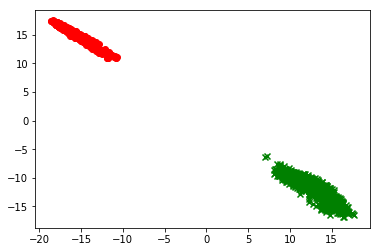

In [13]:
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats
train(model, criterion, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')
plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')

In [ ]:
## class 4: pure part

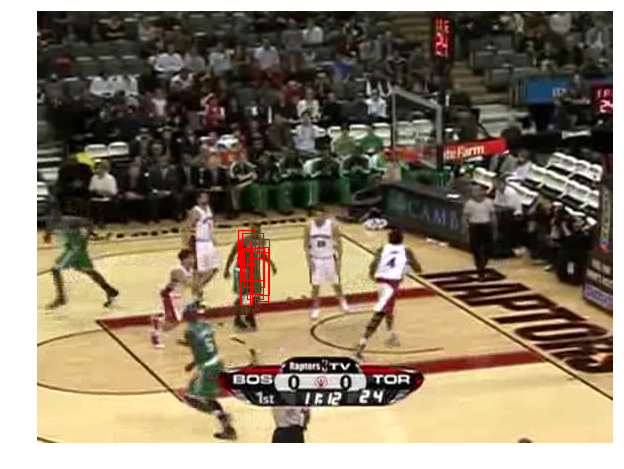

In [14]:
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),target_bbox,
                           opts['n_pos_init'], opts['overlap_pos_init'])
#neg_examples = gen_samples(SampleGenerator('uniform', image.size, 1,2,1.1),target_bbox, 1000, [0,0.1])
#neg_examples = gen_samples(SampleGenerator('hole', image.size, 0.3,2.0),target_bbox, 1000, [0,0.5])
neg_examples = gen_samples(SampleGenerator('part', image.size, 1,2.0,1.1),target_bbox, 1000, [0.2,0.6])
neg_examples.shape
show_bbox(image,neg_examples[:10,:])

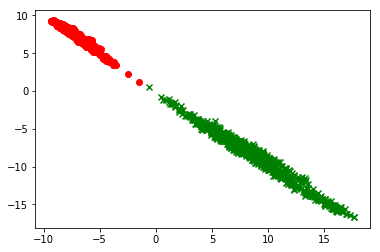

In [15]:
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats
train(model, criterion, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')

plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')

In [16]:
## mix 
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
neg_examples = np.concatenate([
                    gen_samples(SampleGenerator('uniform', image.size, 1, 2, 1.1), 
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init']),
                    gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init'])])
neg_examples = np.random.permutation(neg_examples)

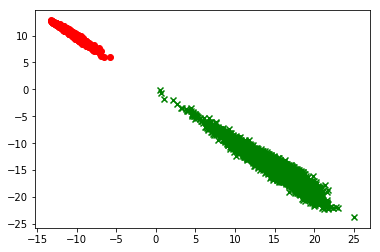

In [17]:
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats
train(model, criterion5, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')

plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')

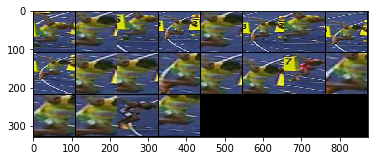

In [8]:
neg_scores,top_idx = neg_out[:,1].topk(20)
top_idx = top_idx.cpu().numpy()
show_grid(image,neg_examples[top_idx],20)


In [7]:
    model.eval()
    pos_scores = model(pos_feats,in_layer='fc4',out_layer='fc6')
    pos_scores = pos_scores.data
    threshholds,idx = pos_scores[:,1].topk(10,largest = False)
    threshhold = threshholds.mean()
    threshhold

2.750631809234619

In [8]:
pos_scores


-4.0168  3.8711
-3.2203  3.9759
-3.7425  4.1790
       ⋮        
-3.6220  4.4351
-4.3390  4.6118
-4.0329  3.7096
[torch.cuda.FloatTensor of size 500x2 (GPU 0)]

In [9]:
    # Init sample generators
    sample_generator = SampleGenerator('gaussian', image.size, opts['trans_f'], opts['scale_f'], valid=True)
    pos_generator = SampleGenerator('gaussian', image.size, 0.1, 1.2)
    neg_generator = SampleGenerator('uniform', image.size, 1.5, 1.2)

    # Init pos/neg features for update
    pos_feats_all = [pos_feats[:opts['n_pos_update']]]
    neg_feats_all = [neg_feats[:opts['n_neg_update']]]

In [10]:
i=i+1

In [11]:
        image = Image.open(img_list[i]).convert('RGB')

        # Estimate target bbox
        samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
        sample_scores = forward_samples(model, image, samples, out_layer='fc6')
        top_scores, top_idx = sample_scores[:,1].topk(5)
        top_idx = top_idx.cpu().numpy()
        target_score = top_scores.mean()
        target_bbox = samples[top_idx].mean(axis=0)

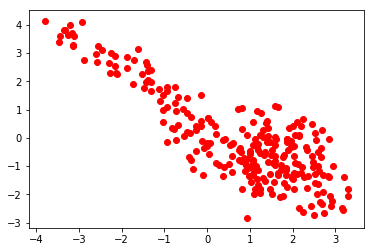

In [12]:
plt.scatter(sample_scores[:,0],sample_scores[:,1],c='r',marker='o')

In [13]:
sample_scores


 2.6974 -1.3198
 1.7729 -0.6896
 0.8012 -0.5136
 1.7257 -0.9730
 2.0277 -0.2958
-1.3835  2.0529
 0.8246 -1.8043
-1.0400  0.9976
-2.8785  2.7438
-0.0087 -0.3057
-3.3480  3.7969
 1.0980 -0.9785
 0.8213  0.2952
 1.4916 -0.6255
 2.6815 -2.3503
-1.3713  1.9960
 2.6292 -2.2869
 2.3313 -0.4448
 2.6032 -1.6399
-3.3172  3.8123
-0.9380  1.7999
 1.0294 -1.0004
-1.1068  1.3129
 1.1659  0.9540
-0.1465  0.4175
-2.1082  2.2701
 2.3219 -0.3153
 2.0091 -1.4589
 1.3050  0.0262
 1.5656 -1.5643
-0.6796  0.4479
 1.1720 -1.4419
 2.2456 -2.6311
 1.7280 -1.1355
-0.3910  0.1801
-1.1300  1.7179
 1.8767 -0.1511
 1.3502 -0.5058
 1.1144 -0.2416
 2.0343 -1.2588
 2.6160 -1.1740
 2.1111  0.5657
 2.1558  0.0860
-2.2760  2.3000
 0.7377 -0.8028
 0.9992 -0.4789
 2.9418 -0.9906
 1.4066  0.5856
 0.5778 -1.2278
 1.1182 -1.8161
-3.7999  4.1453
 2.4266 -2.4199
 2.3234 -1.7748
 1.4784 -1.2776
-0.3402 -1.0881
 2.5245  0.1551
 1.1068 -1.1551
 3.1868 -2.5470
 0.4012 -1.0321
 2.5881 -1.0063
 1.2952 -1.4158
-0.4666  0.2103
 2.5923

In [7]:
def show_grid(image,samples,num):
    image = np.asarray(image)
    sample_arr = list()
    image = np.asarray(image)
    for i in range(num):
        sample_img = crop_image(image,samples[i],107,16)
        sample_arr.append(sample_img)
    d = np.stack(sample_arr,axis=0)
    torch_img = torchvision.utils.make_grid(torch.from_numpy(np.transpose(d,(0,3,1,2))))
    npimg = torch_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

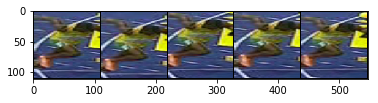

In [15]:
show_grid(image,samples[top_idx],5)

In [26]:
sample_scores = sample_scores.cpu().numpy()

In [32]:
a = (sample_scores[:,1]>1)&(sample_scores[:,1]<2)

In [63]:
b = sample_scores[:,1]<8

In [64]:
idx = a&b

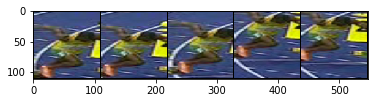

In [33]:
show_grid(image,samples[a],5)

In [59]:
            pos_examples = gen_samples(pos_generator, target_bbox, 
                                       opts['n_pos_update'],
                                       opts['overlap_pos_update'])
            neg_examples = gen_samples(neg_generator, target_bbox, 
                                       opts['n_neg_update'],
                                       opts['overlap_neg_update'])

            # Extract pos/neg features
            pos_feats = forward_samples(model, image, pos_examples)
            neg_feats = forward_samples(model, image, neg_examples)


In [60]:
            
            model.eval()
            pos_scores = model(pos_feats,in_layer='fc4',out_layer='fc6')
            pos_scores = pos_scores.data


In [38]:
pos_scores


-3.5577  3.8031
-2.8522  3.3336
-3.4589  3.5774
-2.1108  3.0934
-3.1982  3.5573
-3.6942  3.6676
-3.3865  3.5900
-2.5525  3.8466
-3.4264  3.7893
-3.2519  3.6388
-2.8243  3.4025
-2.4571  3.8304
-3.4870  3.5806
-1.6091  3.1432
-3.5831  3.9889
-2.5896  2.7543
-3.2498  4.0782
-3.1694  3.5598
-3.2458  3.7253
-2.4467  3.0891
-3.3092  3.2692
-3.5938  3.9718
-3.5374  3.7926
-2.1959  3.1681
-3.0744  4.2159
-2.1278  2.7060
-2.3538  3.3179
-3.1165  3.7789
-3.0152  3.6613
-3.0070  3.3978
-3.1993  3.7047
-3.6332  3.9477
-2.6822  3.6270
-2.9156  3.4418
-3.4427  3.7290
-2.5436  3.6399
-3.4710  3.7082
-3.0907  3.4434
-3.3942  3.4440
-3.0855  3.5404
-3.2080  3.8473
-2.6269  2.5224
-2.9575  3.5518
-2.5853  3.6394
-2.6420  3.2040
-3.4990  3.6009
-3.2920  3.5528
-3.6364  3.8685
-3.2834  3.7717
-3.3656  3.4914
[torch.cuda.FloatTensor of size 50x2 (GPU 0)]

In [61]:
            pos_idx = pos_scores[:,1] > threshhold
            
            pos_idx


 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 1
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.cuda.ByteTensor of size 50 (GPU 0)]

In [62]:
pos_idx = torch.range(0,49).cuda()*pos_idx.float()
pos_idx

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].
  """Entry point for launching an IPython kernel.



  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
  0
  0
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
  0
 35
 36
 37
 38
 39
  0
 41
 42
 43
 44
 45
 46
 47
 48
 49
[torch.cuda.FloatTensor of size 50 (GPU 0)]

In [63]:
            pos_idx = pos_idx.long()
            pos_feats_all.append(pos_feats.index_select(0,pos_idx))
            
            #pos_feats_all.append(pos_feats)
            neg_feats_all.append(neg_feats)

In [65]:
pos_feats.index_select(0,pos_idx)


  0.0000   0.0000   0.0000  ...    0.0000   6.2415   0.0000
  0.0000   0.0000   0.0000  ...    0.0000  10.2022   5.4142
  0.0000   0.0000   0.0000  ...    0.0000   2.5147   2.5209
           ...               ⋱              ...            
  0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
  0.0000   0.0000   0.0000  ...    0.0000   0.0000   1.7273
  0.0000   0.0000   0.0000  ...    0.0000   5.2296   9.0434
[torch.cuda.FloatTensor of size 50x4608 (GPU 0)]

In [39]:
pos_feats = pos_feats.select

In [40]:
pos_feats

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/torch/lib/THC/generic/THCTensorCopy.c:70